In [1]:
import numpy as np
import math
import time
import os
import matplotlib.pyplot as plt

Forward Propagation:

In [2]:
class activation_fns:

    def sigmoid(self, Z):

        A=1/(1+np.exp(-Z))
        assert(A.shape == Z.shape)

        return A

    def ReLU(self, Z):

        A = np.maximum(0,Z)
        assert(A.shape == Z.shape)

        return A

    def LeakyReLU(self, Z , leakage=0.01 ):

        A=np.maximum(leakage*Z,Z)
        assert(A.shape == Z.shape)

        return A

    def tanh(self, Z):
    #    check
        A=np.tanh(Z)
        assert(A.shape == Z.shape)

        return A


In [3]:
def initialize_parameters( architecture, activation, initialization="random"):
    
    init_epsilon=0.01
    
    if initialization == "He" or activation == "ReLU":
        return initialize_parameters_he(architecture)
    
    if initialization == "Xavier" or activation == "tanh":
        return initialize_parameters_xavier(architecture)
    
    if initialization == "random":
        return initialize_parameters_random(architecture,init_epsilon)
    

def initialize_parameters_random(architecture,init_epsilon):
    L=len(architecture)
    
    Theta=[None]*(L-1)

    for l in range(L-1):
        Theta[l]=np.random.randn( architecture[l+1] , architecture[l]+1 ) * (2*init_epsilon) - init_epsilon
    
    return Theta

    
def initialize_parameters_he(architecture):
    L=len(architecture)
    
    Theta=[None]*(L-1)

    for l in range(L-1):
        Theta[l]=np.random.randn( architecture[l+1] , architecture[l]+1 ) * math.sqrt(2/architecture[l])
        #fix previous layer_dims
    
    return Theta

def initialize_parameters_xavier(architecture):
    L=len(architecture)
    
    Theta=[None]*(L-1)
    
    for l in range(L-1):
        Theta[l]=np.random.randn( architecture[l+1] , architecture[l]+1 ) * math.sqrt(1/architecture[l])
        #fix previous layer_dims
        
    return Theta

In [4]:
def forward_propagate( X , Theta , activation ):
    
    L=len(Theta)
    
    Z=[None]*(L+1)
    A=[None]*(L+1)

    A[0]=X
    
    act_fns = activation_fns()
    g=getattr( act_fns, activation )
    
    for l in range(1,L):
        Z[l] = A[l-1] @ Theta[l-1].T
        A[l] = g(Z[l])
        bias= np.ones( (A[l].shape[0],1) )
        A[l] = np.c_[ bias , A[l] ]
    
    g=getattr( act_fns, "sigmoid" )
        
    Z[L] = A[L-1] @ Theta[L-1].T
    A[L] = g(Z[L])
    y=A[L]
    
    return Z,A,y

Loss function:

In [5]:
def compute_cost(y,Y,Theta,Lambda):
    
    m=Y.shape[0]
    J = (-1/m)*np.sum(Y*np.log(y) + (1-Y)*np.log(1-y))

    reg_term=0
    
    for l in range(len(Theta)):
        reg_term+=np.sum( np.power(Theta[l][:,1:],2) )
        
    J = J + (Lambda/(2*m))*reg_term    

    return J


Backpropagation:

In [6]:
class activation_fns_derivative:

    def dsigmoid(self, Z,A):

        dg=(A*(1-A))[:,1:]

        return dg

    def dReLU(self, Z,A):

        dg=Z.copy()
        dg[dg <= 0] = 0
        dg[dg > 0] = 1

        return dg

    def dLeakyReLU(self, Z,A,leakage=0.01):

        dg=Z.copy()
        dg[dg > 0] = 1
        dg[dg <= 0] = leakage

        return dg

    def dtanh(self, Z,A):
    #    check

        dg=(1-np.power(A,2))[:,1:]

        return dg


In [7]:
def compute_gradients(Theta,Lambda,Z,A,Y,activation):
    
    m=Y.shape[0]
    L=len(Theta)
    Err=[None]*(L+1)  #L
    
    act_fns_derivative = activation_fns_derivative()
    dg=getattr( act_fns_derivative , str("d")+activation )
    
    Err[L]=A[L]-Y
    
    for l in range(L-1,0,-1):
        Err[l] = (Err[l+1]@Theta[l])[:,1:] * dg(Z[l],A[l])  
    
    Acc=[None]*(L+1)
    
    for l in range(L-1,-1,-1):
        Acc[l] = Err[l+1].T @ A[l]
        
    Theta_grad=[None]*(L)
    
    for l in range(L):
        Theta_grad[l] = (1/m)*Acc[l] + (Lambda/m)*np.c_[ np.zeros((Theta[l].shape[0] , 1)) , Theta[l][:,1:] ]
        
    return Theta_grad
        
    
         

Optimizer:

In [8]:
def gradientDescent(Theta,Theta_grad,alpha):
    
    L=len(Theta)
    
    for l in range(L):
        Theta[l] = Theta[l] - alpha*Theta_grad[l]     
        
        #check equation
    
    
    return Theta    

Neural Network:

In [9]:
def DNN(X,Y,architecture,optimizer,alpha,Lambda,model_dir,activation,iterations,initialization="random" ):
    
    print("\nData Analysis...\n")
    print("Number of Samples : "+str(X.shape[0]))
    print("Number of features : "+str(X.shape[1]-1))  #bias added
    print("Number of Output Units : "+str(Y.shape[1]))
    
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        print("\nDirectory "+model_dir+" Created")
    else:
        print("\nDirectory "+model_dir+ " already exists")    
    
    Theta = initialize_parameters(architecture,activation,initialization)
    
    print("\nInitialialising Neural Network Training...\n")
    
    tic = time.time()
    
    cost=list()
    
    for i in range(iterations):
        Z,A,y = forward_propagate(X,Theta,activation)
        J=compute_cost(y,Y,Theta,Lambda)
        
        if i%100 == 0:
            print("Cost at iteration "+str(i)+" : "+str(J))
            cost.append(J)
        
        Theta_grad = compute_gradients(Theta,Lambda,Z,A,Y,activation)

        Theta = gradientDescent(Theta,Theta_grad,alpha)
        
        if i%10000 == 0:                #model_save_interval, account for Adam
            np.save(model_dir+"/model_itr_"+str(i)+".npy",Theta)

    print("\nProgress of Loss over iterations:")
    plot_cost(cost, iterations)
    
    np.save(model_dir+"/final_model.npy",Theta)
    
    toc=time.time()
    
    print("\nTraining time : "+str(round(toc-tic,3))+" s\n")
   
    return Theta


In [10]:
def plot_cost(losses, nepochs):
    
    nepochs = list(range(0,nepochs,100))
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.plot(nepochs, losses, 'm', linewidth = "5")
    plt.show()

In [11]:
def predict(X , Theta , activation):

    Z,A,y=forward_propagate(X,Theta,activation)

    return y

Evaluation:

In [12]:
def evaluate( X, Y, Theta, activation, settype ="Train", X_test=None, Y_test=None):

    y=predict(X,Theta,activation)
    
    J=compute_cost(y,Y,Theta,Lambda=0)
    
    y=(y > 0.5).astype(int)

    TP=np.sum((y==1)&(Y==1))
    FP=np.sum((y==1)&(Y==0))
    FN=np.sum((y==0)&(Y==1))
    TN=np.sum((y==0)&(Y==0))

    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)

    F1_score = 2*Precision*Recall / (Precision + Recall)

    accuracy=100 - np.mean(np.abs(Y - y))*100
    
    print("---Running Diagnostics on "+settype+" Set ---\n")
    print("True Positive --> "+str(TP))
    print("False Positive --> "+str(FP))
    print("False Negative --> "+str(FN))
    print("True Negative --> "+str(TN))
    
    print("\nFinal "+settype+" Set Cost : "+str(round(J,3)))            #test and train final cost
    print(settype+" Accuracy = "+str(accuracy)+"%")

    print("\nf1 Score = "+str(round(F1_score,4))+"\n")

    if settype == "Train":
        if X_test is not None :
            evaluate( X_test, Y_test, Theta, activation, settype ="Test")

    if settype == "Test":
        return


Helper functions:

In [13]:
def add_bias(x):
    
    X=np.c_[np.ones((x.shape[0],1)),x]
    
    return X

In [14]:
def normalize(X):
    
    mu=np.mean(X,axis=0,keepdims=True)
    sigma=np.std(X,axis=0,keepdims=True)
    
    X_norm=(X-mu)/sigma
    
    return X_norm,mu,sigma

Using Neural Networks for Iris Classification:

In [15]:
from sklearn import datasets


Data Analysis...

Number of Samples : 150
Number of features : 2
Number of Output Units : 3

Directory IrisClassifier already exists

Initialialising Neural Network Training...

Cost at iteration 0 : 2.0495447612480007
Cost at iteration 100 : 1.466521364770246
Cost at iteration 200 : 0.9961383398324473
Cost at iteration 300 : 0.9633615776721774
Cost at iteration 400 : 0.9358450749158442
Cost at iteration 500 : 0.948024554360271
Cost at iteration 600 : 0.9429796692093216
Cost at iteration 700 : 0.938711039282065
Cost at iteration 800 : 0.9344362910860576
Cost at iteration 900 : 0.9300980582033506

Progress of Loss over iterations:


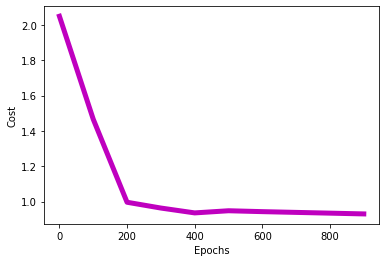


Training time : 0.202 s



In [18]:
iris = datasets.load_iris()

X=iris.data[:,:2]
Y=iris.target

X=np.c_[np.ones((X.shape[0],1)),X]

num_labels=3
Y=np.expand_dims(Y,axis=1)

Y=np.c_[Y,np.zeros((Y.shape[0],num_labels-1))]
Y=Y.astype(int)

for i in range(Y.shape[0]):
    if( Y[i,0] != 1 ):    
        Y[i,Y[i,0]-1]=1
        Y[i,0]=0

architecture=[2,10,3]
alpha=0.9
Lambda=0
model_dir="IrisClassifier"
iterations=1000
optimizer="gradientDescent"
activation="sigmoid"

Theta=DNN(X,Y,architecture,optimizer,alpha,Lambda,model_dir,activation,iterations)

In [19]:
evaluate(X,Y,Theta,activation, settype ="Train")

---Running Diagnostics on Train Set ---

True Positive --> 95
False Positive --> 37
False Negative --> 55
True Negative --> 263

Final Train Set Cost : 0.926
Train Accuracy = 79.55555555555556%

f1 Score = 0.6738

